<br><br>
<a id='Header' style="font-size:40px; color:#1D2951; text-decoration:none; text-align:center;">
    <center><b>Loan investigation findings</b></center>
</a>

<br><br>

<a id='inv' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Investigation Overview</b></a>


We are meant here to give insights about loan dataset answering questions like<br>
what factors that effect the loan status?<br>
What affects the borrower’s APR?<br>

We begin by cleaning the dataset which consisted of 81 variables, the main focus fall on just these variables <br>
{ 'ListingCreationDate', 'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'ProsperRating (Alpha)', 'ListingCategory (numeric)', 'Occupation', 'EmploymentStatus', 'IsBorrowerHomeowner', 'DebtToIncomeRatio', 'IncomeRange', 'StatedMonthlyIncome', 'Recommendations', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'Investors' }<br>

Here we will give a short overview of their meanings, then we will see some correlations between them and build up until we get a compelete overview and have a meaningful insights about the factors we are interested in.

In [1]:
# import all packages and set plots to be embedded inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import re

# plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
# plt.style.use('seaborn-white')
plt.style.use('seaborn-deep')

pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [2]:
class Color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [7]:
# load datasets
loans_df = pd.read_csv('prosperLoanData.csv')
schema_df = pd.read_csv('schema_ProsperLoanData.csv', index_col = 'Variable')

selected_cols = ['ListingCreationDate', 'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'ProsperRating (Alpha)', 'ListingCategory (numeric)', 'Occupation', 'EmploymentStatus', 'IsBorrowerHomeowner', 'DebtToIncomeRatio', 'IncomeRange', 'StatedMonthlyIncome', 'Recommendations', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'Investors']
schema_df.rename({'ListingCategory':'ListingCategory (numeric)'}, inplace=True)
df = loans_df[selected_cols]

In [17]:
# datatypes of the dataframe
categorical_cols = ['Term', 'LoanStatus', 'ProsperRating (Alpha)', 'ListingCategory (numeric)', 'Occupation', 'EmploymentStatus', 'IncomeRange']
boolean_cols = ['IsBorrowerHomeowner'] # already converted
datetype_cols = ['ListingCreationDate', 'ClosedDate'] 
numeric_cols = ['BorrowerAPR', 'StatedMonthlyIncome', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'Investors'] # already converted

In [8]:
# I printed them here to easily go back and check their meaning by searching for {*column_name} or search for schema_meanings
print(f'\t\t\t\t\t\t\t{Color.RED}schema_meanings{Color.END}\n')

for col_name in selected_cols:
    print(f'{Color.GREEN}*{col_name}{Color.END}', ': ', schema_df.loc[col_name, 'Description'])

							schema_meanings

*ListingCreationDate :  The date the listing was created.
*Term :  The length of the loan expressed in months.
*LoanStatus :  The current status of the loan: Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.
*ClosedDate :  Closed date is applicable for Cancelled, Completed, Chargedoff and Defaulted loan statuses. 
*BorrowerAPR :  The Borrower's Annual Percentage Rate (APR) for the loan.
*ProsperRating (Alpha) :  The Prosper Rating assigned at the time the listing was created between AA - HR.  Applicable for loans originated after July 2009.
*ListingCategory (numeric) :  The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 

<hr>

## Cleaning part
#### feel free to skip it to the Visualization-Insights part

In [12]:
# DROP NaN
df.dropna(inplace=True)

In [9]:
values = re.findall('[0-9]+\s*- ([A-Za-z ]+)', schema_df.loc['ListingCategory (numeric)', 'Description'])
keys = range(0, 21)
mapping_ListCategory = dict(zip(keys, values))
df['ListingCategory'] = df['ListingCategory (numeric)'].apply(lambda x: mapping_ListCategory[x])

In [14]:
ProsperRating_classes = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ProsperRatingClasses = pd.CategoricalDtype(ordered=True, categories=ProsperRating_classes)
df['ProsperRating'] = df['ProsperRating (Alpha)'].astype(ProsperRatingClasses);

In [15]:
def decorate_barPlots(ax, title='TITLE', hideAxes=True, direction='v', rotateTextdeg=0):
    '''
        ax : matplotlib.axes._subplots.AxesSubplot
        hideAxes : Hide right and top axes of the plot
        annotate : add numbers related to bar sizes
        direction : v or h which stands for vertical and horizontal
    '''

    if direction == 'v':
        for p in ax.patches:
            bar_length = round(p.get_height(), 4)
            ax.annotate(str(bar_length), xy=(p.get_x() + p.get_width() / 2.0, bar_length),
            xytext=(3, 3),
            textcoords='offset points',
            ha='center',
            va='bottom',
            rotation = rotateTextdeg
                       )
    elif direction == 'h':
        for p in ax.patches:
            bar_length = round(p.get_width(), 4)
            ax.annotate(str(bar_length), xy=(bar_length, p.get_y() + (p.get_height() / 2.0)),
            xytext=(25, 1),
            textcoords='offset points',
            ha='center', # Horizontal Alignment: 'center', 'right', 'left'
            va='center_baseline', # Vertical Alignment:'top', 'bottom', 'center', 'baseline', 'center_baseline'
            rotation = rotateTextdeg
                                )
    else:
        print('Not Annotated!')


    if hideAxes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

    title_obj = ax.set_title(f'{title}', pad=20, fontsize=15)
    plt.setp(title_obj, color='#1D2951');

<hr>
<hr>
<hr>

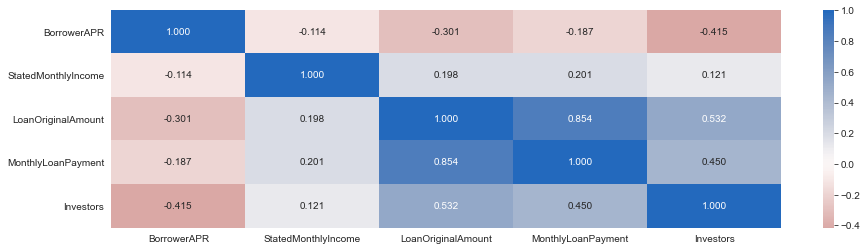

In [18]:
fig = plt.figure(figsize=(15, 4))
sns.heatmap(df[numeric_cols].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

from the correlation map above we can see that there is a negative correlation between Investors and BorrowerAPR
and of course the monthy loan payment increases as the Original loan increases

Now we will see some relations associated with BorrowerAPR

In [19]:
IncomeRange_classes = ['$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']
IncomeClasses = pd.CategoricalDtype(ordered=True, categories=IncomeRange_classes)
df['IncomeRange'] = df['IncomeRange'].astype(IncomeClasses);

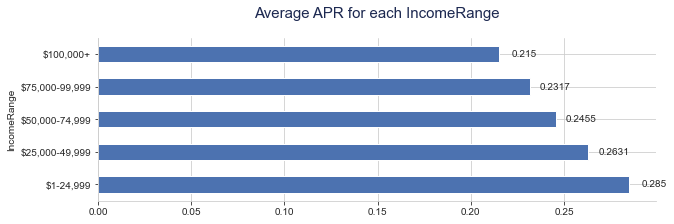

In [20]:
income_apr = df.groupby('IncomeRange')['BorrowerAPR'].sum() / df.groupby('IncomeRange')['BorrowerAPR'].count()

fig = plt.figure(figsize=(10, 3))
ax = income_apr.plot(kind='barh')
decorate_barPlots(ax, title='Average APR for each IncomeRange', direction='h')

People with the lower incomeRange tend to have higher average APR, it is strange though. <br>
mabye due to their payment-delay? <br>
or maybe due to they have less investors? <br>
or mabye due to the fact that these people tend to NEED loans more than the other (e.g. for houses or Autos ..etc.).

We will see the relation between IncomeRange and the others to see why lower income range have higher APR.

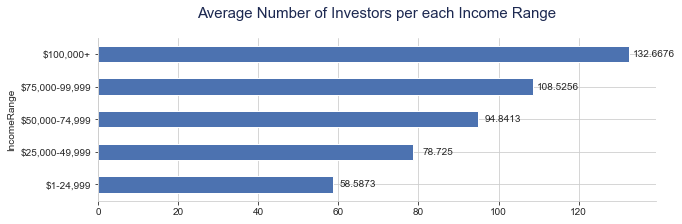

In [21]:
income_apr = df.groupby('IncomeRange')['Investors'].sum() / df.groupby('IncomeRange')['Investors'].count()

fig = plt.figure(figsize=(10, 3))
ax = income_apr.plot(kind='barh')
decorate_barPlots(ax, title='Average Number of Investors per each Income Range', direction='h')

it seems like what we said above was true, people with lower income range tend to have fewer investors.

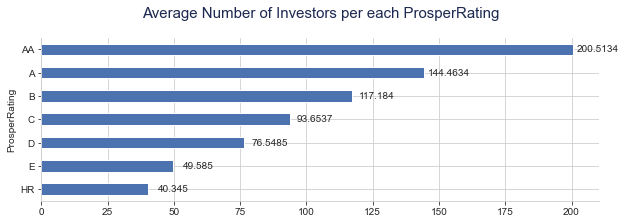

In [22]:
income_apr = df.groupby('ProsperRating')['Investors'].sum() / df.groupby('ProsperRating')['Investors'].count()

fig = plt.figure(figsize=(10, 3))
ax = income_apr.sort_values().plot(kind='barh')
decorate_barPlots(ax, title='Average Number of Investors per each ProsperRating', direction='h')

Invistors increase is indication of a good ProsperRating.

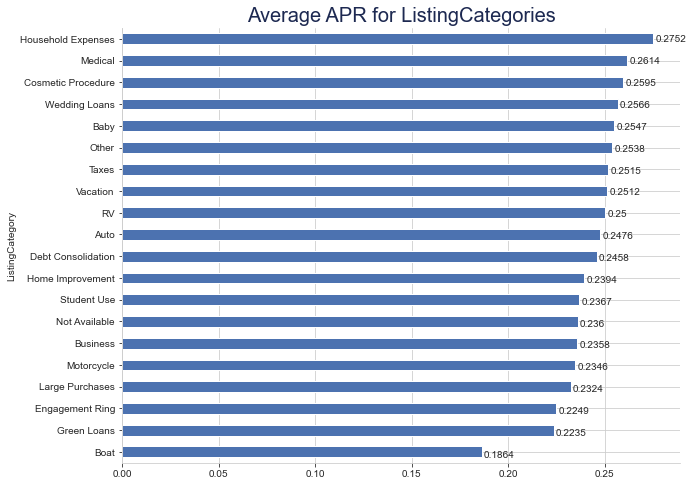

In [23]:
Average_APR = df.groupby('ListingCategory')['BorrowerAPR'].sum()/ df.groupby('ListingCategory')['BorrowerAPR'].count()
ax = Average_APR.sort_values().plot(kind='barh', figsize=(10,8))

for p in ax.patches:    
    ax.annotate(str(round(p.get_width(), 4)), ( p.get_width() * 1.005, p.get_y() * 1.005))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_obj = plt.title('Average APR for ListingCategories', fontsize=20)
plt.setp(title_obj, color='#1D2951');

So, it seems that the HIGHEST APR tends to go for Household Expenses followed by Medical expenses.

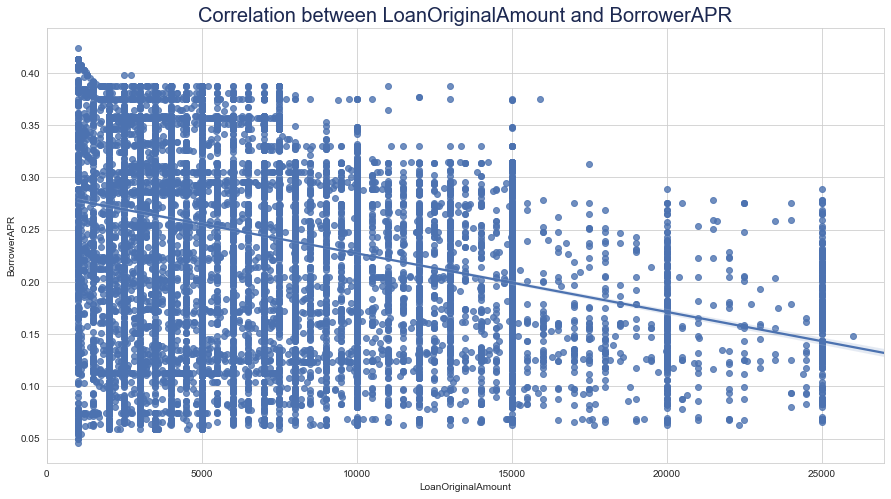

In [24]:
plt.figure(figsize=(15,8))
sns.regplot(data=df, x="LoanOriginalAmount", y="BorrowerAPR")
plt.xlim(0, 27000)

title_obj = plt.title('Correlation between LoanOriginalAmount and BorrowerAPR', fontsize=20)
plt.setp(title_obj, color='#1D2951');

APR decreases as the LoanOriginalAmount increases. seems convincing.

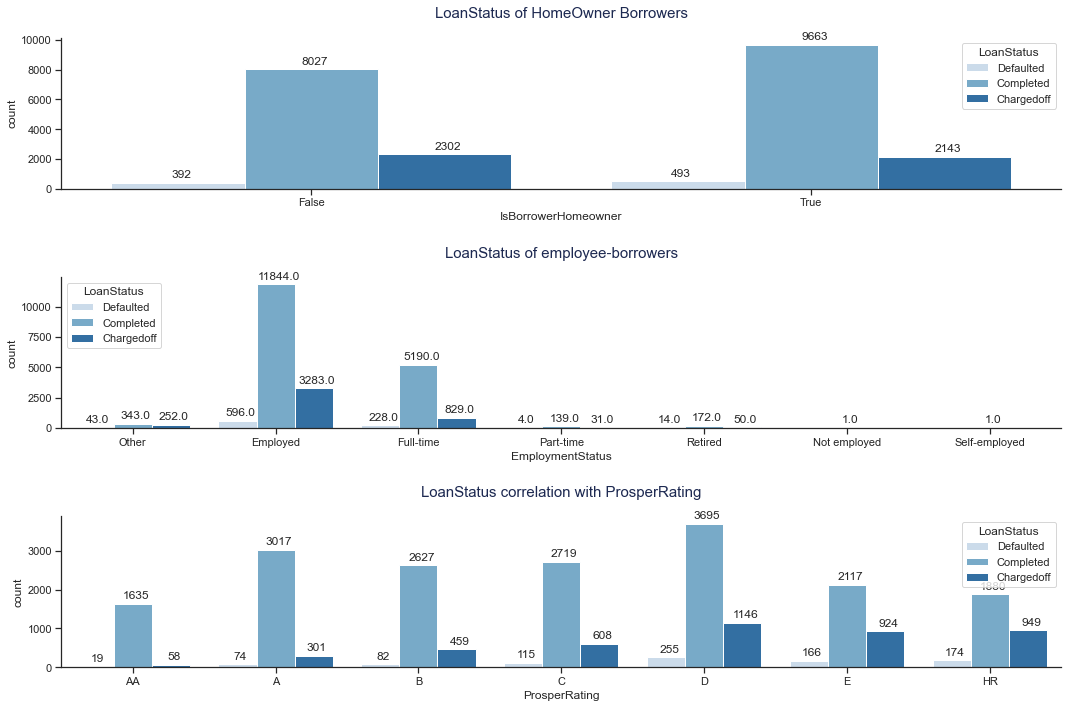

In [25]:
fig = plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.set_style('white')

ax = plt.subplot(3, 1, 1)
ax = sns.countplot(data=df, x='IsBorrowerHomeowner', hue='LoanStatus', palette='Blues') # palette='crest'
decorate_barPlots(ax, title='LoanStatus of HomeOwner Borrowers', direction='v')

ax = plt.subplot(3, 1, 2)
ax = sns.countplot(data=df, x='EmploymentStatus', hue='LoanStatus', palette='Blues')
decorate_barPlots(ax, title='LoanStatus of employee-borrowers', direction='v')

ax = plt.subplot(3, 1, 3)
ax = sns.countplot(data=df, x='ProsperRating', hue='LoanStatus', palette='Blues')
decorate_barPlots(ax, title='LoanStatus correlation with ProsperRating', direction='v')

fig.tight_layout(h_pad=2)

Borrowers with their own houses tend to complete the loan more than the others. <br>
Number of Chargedoff borrowers tend to follow the ProsperRating scale, as risk increases charing increases which is pretty obvious :D

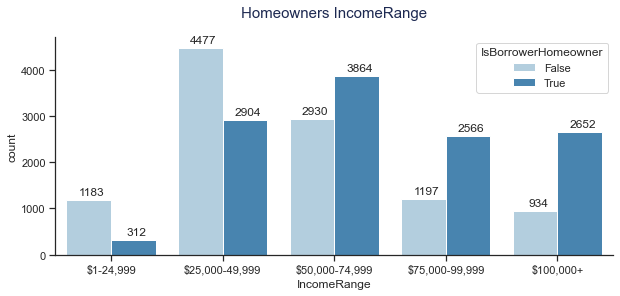

In [26]:
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
sns.set_style('white')
ax = sns.countplot(data=df, x='IncomeRange', hue='IsBorrowerHomeowner', palette='Blues')
decorate_barPlots(ax, title='Homeowners IncomeRange', direction='v')

Ratio between people with higher IncomeRange who own houses to who don't is higher than the people with lower IncomeRange and therefore this category have higher creditability for completing the loan which confirms the previous results.

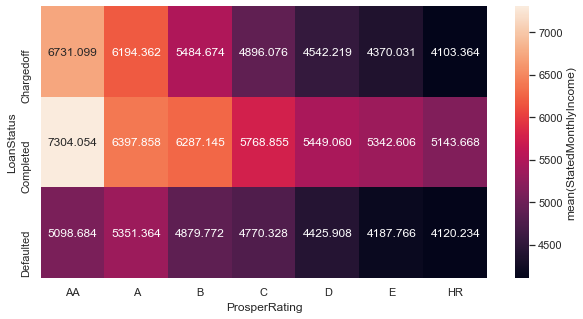

In [27]:
plt.figure(figsize=(10,5))
avgs = df.groupby(['LoanStatus', 'ProsperRating']).mean()['StatedMonthlyIncome']
avgs = avgs.reset_index(name = 'StatedMonthlyIncome_AVG');
avgs = avgs.pivot(index = 'LoanStatus', columns = 'ProsperRating', values = 'StatedMonthlyIncome_AVG');
sns.heatmap(avgs, annot = True, fmt = '.3f', cbar_kws = {'label' : 'mean(StatedMonthlyIncome)'});

This summarize the correlations between monthlyIncome, ProsperRating, and LoanStatus
As MonthlyIncome increases, the borrower gain a good prosperrating and eventually he completes the loan.

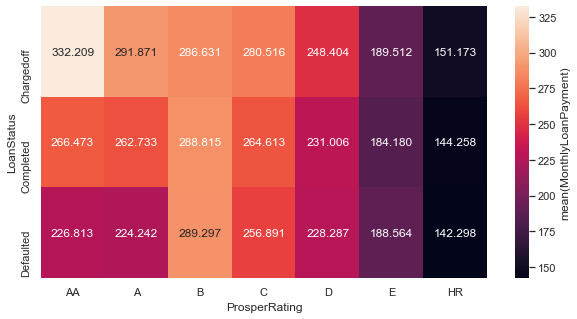

In [28]:
plt.figure(figsize=(10,5))
avgs = df.groupby(['LoanStatus', 'ProsperRating']).mean()['MonthlyLoanPayment']
avgs = avgs.reset_index(name = 'MonthlyLoanPayment_AVG');
avgs = avgs.pivot(index = 'LoanStatus', columns = 'ProsperRating', values = 'MonthlyLoanPayment_AVG');
sns.heatmap(avgs, annot = True, fmt = '.3f', cbar_kws = {'label' : 'mean(MonthlyLoanPayment)'});

We got an interesting results here, indicating that if the monthly loan payment increased over a certain point, EVEN IF the borrower is considered in a AA-ProsperRating-category, debt is unlikely to be collected.

<a id='conclusions' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Conclusions</b></a>

Here we focused on giving insights about two questions: <br>
- What factors affect a loan's outcome status? <br>
- What affects the borrower’s APR? <br>
And we saw that employed borrowers, obviously, have higher monthly income, and as the monthly income increases the prosper rating increases and eventually they more likely to complete their loan. <br>
HouseOwner-borrowers are likely to complete their loan compared to the borrowers who don't have houses. <br>
Investors increase is an indication of a good prosper rating, and eventually the borrower is likely to complete the loan.<br><br>
APR is mainly affected by the original amount of loan, and the Listing category for the loan. <br>
interestingly, APR increases as the original amount of loan increases. and the highest APR-listing-category is Household expenses followed by medical expenses. <br>
APR is also affected by the borrower income-range. it increases as the income-range decreases.